
This Notebook is prepared by Dara Rouholiman as part of his Udacity Machine Learning Nanodegree Capstone Project. 

Table of Contents: 
 
1.   Data and Solution Summary 
2.   GPU capacity calculations (revised for google colab)
3.   Import the needed libraries and clone/read the Data 
3.   Data Exploration 
4.   Data Pre-processing 
5.   Unet model Implementation 
6.   Results 




**1.   Data and Solution Summary**

Data: The dataset is provided by Booz Allen Hamilton's 2018 Data Science Bowl: Find the nuclei in divergent images to advance medical discovery challenge under Creative Commons license.[8] The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence) to challenge an algorithm's ability to generalize across these variations.  

Solution: an algorithm that uses TensorFlow as its backend and Keras as the framework. The input of the network are images of quantifiable shape (height, width, channels) while the output are corresponding binary masks of shape (height, width, 1). The output result will be a list of indices for the segmentation, pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3). 

**2.GPU capacity calculations (revised for google colab)**

In [5]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print('Gen RAM Free: ' + humanize.naturalsize( psutil.virtual_memory().available ), ' I Proc size: ' + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/ff/24/c1/7e98d678e5be90c88cc151f1f3ef77a96ea3e8266b1aa225a4
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d4/80/38/cfbfd95752f71f3812505b948b43383ddc99eedf835fc13b09
Successfully built humanize
Gen RAM Free: 11.9 GB  I Proc size: 976.9 MB
GPU RAM Free: 564MB | Used: 10875MB | Util  95% | Total 11439MB


**3. Import the needed libraries and clone/read the Data**

In [2]:
#Import necessary modules and set global constants and variables. 
# https://keras.io/
!pip install -q keras
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install tqdm
import cv2
import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import keras.preprocessing.image   # For using image generation
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
#import tqdm                        # Use smart progress meter
#import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline
from subprocess import check_output
import random
import skimage.io
import shutil
from subprocess import check_output
from skimage import transform
import random 
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from tqdm import tqdm

    100% |████████████████████████████████| 61kB 3.0MB/s 


Using TensorFlow backend.


In [3]:
!git clone --recursive https://github.com/darar1/datasciencebowl2018.git
!ls
# Data Path
TRAIN_PATH = 'datasciencebowl2018/stage1_training/'
TEST_PATH = 'datasciencebowl2018/stage1_testing/'

Cloning into 'datasciencebowl2018'...
remote: Counting objects: 32413, done.
remote: Compressing objects: 100% (21150/21150), done.
remote: Total 32413 (delta 11205), reused 32408 (delta 11200), pack-reused 0
Receiving objects: 100% (32413/32413), 79.73 MiB | 50.55 MiB/s, done.
Resolving deltas: 100% (11205/11205), done.
datalab  datasciencebowl2018


In [4]:
print(check_output(["ls", "datasciencebowl2018/"]).decode("utf8"))

stage1_testing
stage1_training



**4. Data Exploration**

Total Images in Training set: 669
Randomly Selected Images: 16, their IDs: ['af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0', '8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d', '81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883', 'be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e', '76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450', '220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a', '3a508d2dc03db46e7f97a2a30eabb62ab2886f3cedfea303de8f6a42e50d20eb', 'd0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f', 'e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243', '514ccfc78cb55988a238d3ac9dc83460aa88382c95d56bcc0559962d9fe481ef', '0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e', 'f43169e3d8b4f71e687945b9e72cbfdfe2e40e68842568e6a30c60d64c1378b6', '2a2032c4ed78f3fc64de7e5efd0bec26a81680b

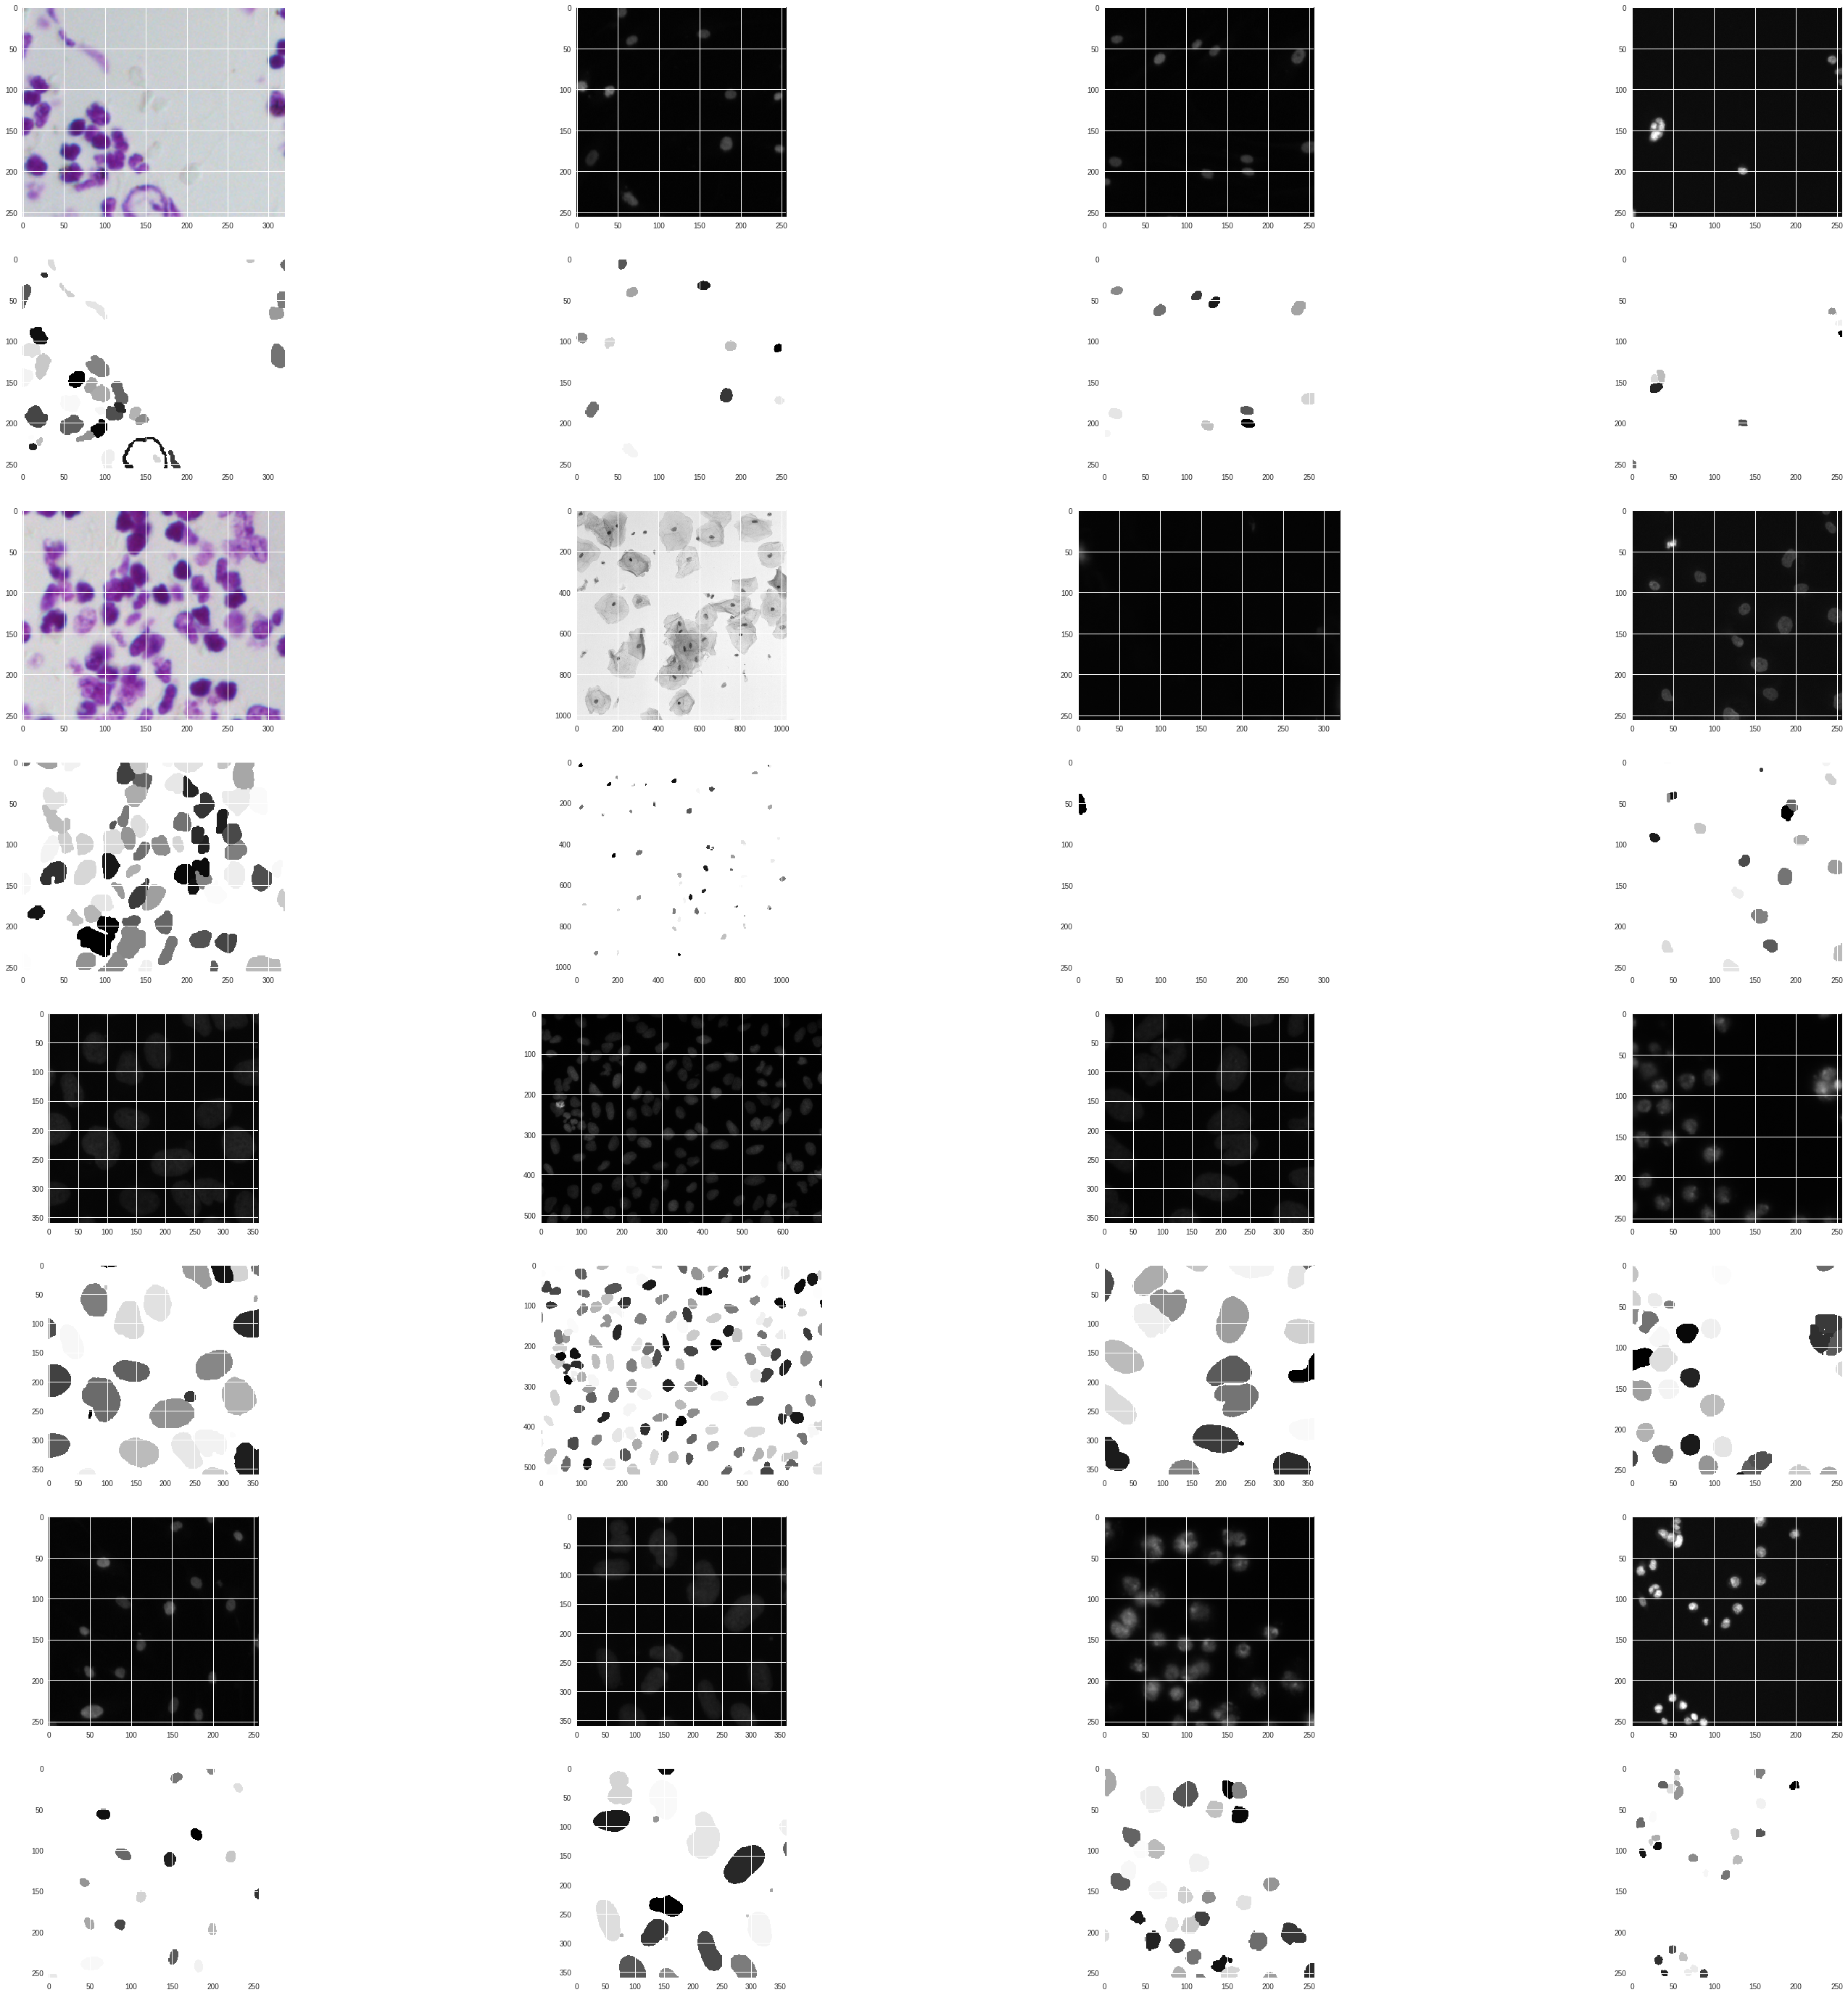

In [5]:
def read_image_labels(image_id):
    # most of the content in this function is taken from 'Example Metric Implementation' kernel 
    # by 'William Cukierski'
    image_file = "datasciencebowl2018/stage1_training/{}/images/{}.png".format(image_id,image_id)
    mask_file = "datasciencebowl2018/stage1_training/{}/masks/*.png".format(image_id)
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

def plot_images_masks(image_ids):
    plt.close('all')
    fig, ax = plt.subplots(nrows=8,ncols=4, figsize=(50,50))
    for ax_index, image_id in enumerate(image_ids):
        image, labels = read_image_labels(image_id)
        img_row, img_col, mask_row, mask_col = int(ax_index/4)*2, ax_index%4, int(ax_index/4)*2 + 1, ax_index%4
        ax[img_row][img_col].imshow(image)
        ax[mask_row][mask_col].imshow(labels)

image_ids = check_output(["ls", "datasciencebowl2018/stage1_training/"]).decode("utf8").split()
print("Total Images in Training set: {}".format(len(image_ids)))
random_image_ids = random.sample(image_ids, 16)
print("Randomly Selected Images: {}, their IDs: {}".format(len(random_image_ids), random_image_ids))
plot_images_masks(random_image_ids)

I noticed some of the edge masks were just lines so I wanted to exclude these from my dataset. I used the following script to flag all masks that are 1 px wide (or empty). There turns out to be about 19 masks in the training set that are flagged.

**5. Data Pre-processing**

In [6]:
!rm datasciencebowl2018/stage1_training/.DS_Store/masks
from skimage.io import imread
for image in os.listdir(TRAIN_PATH):
    try: 
      mask_list = os.listdir("%s%s/masks" % (TRAIN_PATH, image))
      for mask in mask_list:
        try:
            full_path = "%s%s/masks/%s" % (TRAIN_PATH, image, mask)
            inp_mask = imread(full_path)
            if (np.count_nonzero(inp_mask) != 0):
                x_mask, y_mask = np.nonzero(inp_mask)
                size_x = max(x_mask) - min(x_mask) + 1
                size_y = max(y_mask) - min(y_mask) + 1
                if size_x < 2 or size_y < 2: # Flag Mask
                    print(full_path)
            else:
                print("Empty mask: %s" % (full_path))
        except:
          pass
    except:
          pass

rm: cannot remove 'datasciencebowl2018/stage1_training/.DS_Store/masks': Not a directory


In [0]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
ignore_masks = ["ee43930956917b35e8ea9950119904ee43eeaf297ae2d0999a96bce06465119b.png", 
                "976fdddb84f5e86cc06b746252d103836124a0b0fa01865652789ee3ae1ebec0.png", 
                "e512fabd19592b09562cfabb45b7c3bff574d1f6818b7b53b5fede10016dc8b2.png", 
                "b82e80e4f8190720f38ea3fab4a05f133fd862b592db9ffd73f630500c7f94fb.png", 
                "879eb8b1875444d0f9e42755b1007978f9c3706285e862c7c42bf4900d1a5c1f.png", 
                "4713d7309386224347ea05586644b2fad515c272463c1662236109d1755191d9.png", 
                "493e574250a73120c05755367a2d032940563fdad88451d3ac42703fa93e1f8e.png", 
                "7ac528af7d96b1bae71a3b07d3f8de6dcde063c3dc2a84500fae46e46cd76bc6.png", 
                "777459648d2c4c18fe8df79e284fbec4decc5f3ffaf26930ec7d3d457b84ae62.png", 
                "9551f2dad01c71f81d5e2386a99bc963457338d0c79fda0e90e9226f50b5dada.png", 
                "069acba0cce8b22a267edd80e6c4303d9f8dd980bdcea0cf2569079b02cf6b41.png", 
                "4cff40e93297cd84240c4e05d861efc4c6c8ad6cab073968e75fea862639439e.png", 
                "2ec5a0547b47b663b91224a0b0b031ba26c6d81dd8c2271a0142ff50e7a3c90e.png", 
                "e707c768392b287baffc9307f2dc0d6a9993e40bcae8945caf0925bc789e4259.png", 
                "cd443eb126f389fb815a24b65035b306268bcfc3b4ad077c58110c5c1255805b.png", 
                "b9a160bc22b20d83a529f71b75f8ac11bed4f306c3d02d3d5496cefcda91666a.png", 
                "1f06b1d1ef191b4a0ecf28636d017d143114ac3e4760f0eb35f56af006d41a62.png", 
                "e969172b62b37ba15754478b69cefce1bf61534b46b4ac9e80e07a410815cfdc.png", 
                "0a0cb3d0373050e8f63302c2c1ab79c9a35249e98dda568418e79222eb9beb6f.png"]

In [0]:
def read_image_labels(image_id):
    # most of the content in this function is taken from 'Example Metric Implementation' kernel 
    # by 'William Cukierski'
    image_file = "datasciencebowl2018/stage1_training/{}/images/{}.png".format(image_id,image_id)
    mask_file = "datasciencebowl2018/stage1_training/{}/masks/*.png".format(image_id)
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

def data_aug(image,label,angel=30,resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    # Create Afine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    # Randomly cropping image frame
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    # Randomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
    return image, label

In [0]:
#warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 250

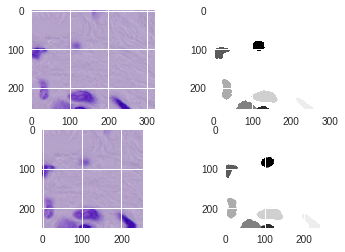

In [8]:
image_ids = check_output(["ls", "datasciencebowl2018/stage1_training/"]).decode("utf8").split()
image_id = image_ids[random.randint(0,len(image_ids))]
image, labels = read_image_labels(image_id)
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(labels)

new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
plt.subplot(223)
plt.imshow(new_image)
plt.subplot(224)
plt.imshow(new_labels)

    100% |████████████████████████████████| 61kB 3.1MB/s 


 **Save the augmented data locally**

In [9]:
def make_data_augmentation(image_ids,split_num):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        image,labels = read_image_labels(image_id)
        if not os.path.exists("datasciencebowl2018/stage1_training/{}/augs/".format(image_id)):
            os.makedirs("datasciencebowl2018/stage1_training/{}/augs/".format(image_id))
        if not os.path.exists("datasciencebowl2018/stage1_training/{}/augs_masks/".format(image_id)):
            os.makedirs("datasciencebowl2018/stage1_training/{}/augs_masks/".format(image_id))
            
        # also save the original image in augmented file 
        plt.imsave(fname="datasciencebowl2018/stage1_training/{}/augs/{}.png".format(image_id,image_id), arr = image)
        plt.imsave(fname="datasciencebowl2018/stage1_training/{}/augs_masks/{}.png".format(image_id,image_id),arr = labels)

        for i in range(split_num):
            new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
            aug_img_dir = "datasciencebowl2018/stage1_training/{}/augs/{}_{}.png".format(image_id,image_id,i)
            aug_mask_dir = "datasciencebowl2018/stage1_training/{}/augs_masks/{}_{}.png".format(image_id,image_id,i)
            plt.imsave(fname=aug_img_dir, arr = new_image)
            plt.imsave(fname=aug_mask_dir,arr = new_labels)

def clean_data_augmentation(image_ids):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        if os.path.exists("datasciencebowl2018/stage1_training/{}/augs/".format(image_id)):
            shutil.rmtree("datasciencebowl2018/stage1_training/{}/augs/".format(image_id))
        if os.path.exists("datasciencebowl2018/stage1_training/{}/augs_masks/".format(image_id)):
            shutil.rmtree("datasciencebowl2018/stage1_training/{}/augs_masks/".format(image_id))


image_ids = check_output(["ls", "datasciencebowl2018/stage1_training/"]).decode("utf8").split()
split_num = 10
make_data_augmentation(image_ids,split_num)
clean_data_augmentation(image_ids)

100%|██████████| 669/669 [00:00<00:00, 817.12it/s]


In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
# Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids,rles

**6. Unet model Implementation**

In [0]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
 
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [15]:
get_unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
#@title Default title text
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

In [0]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train
  # Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [18]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
#
!rm datasciencebowl2018/stage1_training/9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/d4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/9facc652efe19f634639585d692a53dd6c2a8e2f0c9baebdfd85b9b41ec58851/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/f113626a04125d97b27f21b45a0ce9a686d73dee7b5dbc0725d49194ba0203bd/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b/masks/.DS_Store
!rm datasciencebowl2018/stage1_training/b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4/masks/.DS_Store
train_img,train_mask = read_train_data()

# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
668/669 [============================>.] - ETA: 0s
Getting and resizing test images ... 
63/65 [============================>.] - ETA: 0s

In [19]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='nuclei.model.100.UNET', 
                               verbose=1, save_best_only=True)
# get u_net model
u_net = get_unet()
# fit model on train_data
print("\nTraining...")
u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs, 
          validation_split=0.1, callbacks=[checkpointer], 
          verbose=1, shuffle=True)



Training...
Train on 602 samples, validate on 67 samples
Epoch 1/250
602/602 [==============================] - 29s 48ms/step - loss: 0.4454 - dice_coef: 0.2495 - val_loss: 0.2469 - val_dice_coef: 0.4713

Epoch 00001: val_loss improved from inf to 0.24690, saving model to nuclei.model.100.UNET
Epoch 2/250
602/602 [==============================] - 22s 37ms/step - loss: 0.1888 - dice_coef: 0.5910 - val_loss: 0.1714 - val_dice_coef: 0.7024

Epoch 00002: val_loss improved from 0.24690 to 0.17135, saving model to nuclei.model.100.UNET
Epoch 3/250
602/602 [==============================] - 22s 37ms/step - loss: 0.1335 - dice_coef: 0.7375 - val_loss: 0.1315 - val_dice_coef: 0.7733

Epoch 00003: val_loss improved from 0.17135 to 0.13150, saving model to nuclei.model.100.UNET
Epoch 4/250
602/602 [==============================] - 22s 37ms/step - loss: 0.1203 - dice_coef: 0.7590 - val_loss: 0.1213 - val_dice_coef: 0.7906

Epoch 00004: val_loss improved from 0.13150 to 0.12128, saving model to 

602/602 [==============================] - 22s 37ms/step - loss: 0.1004 - dice_coef: 0.8049 - val_loss: 0.1156 - val_dice_coef: 0.8191

Epoch 00005: val_loss improved from 0.12128 to 0.11565, saving model to nuclei.model.100.UNET
Epoch 6/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0948 - dice_coef: 0.8186 - val_loss: 0.1114 - val_dice_coef: 0.8242

Epoch 00006: val_loss improved from 0.11565 to 0.11140, saving model to nuclei.model.100.UNET
Epoch 7/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0908 - dice_coef: 0.8253 - val_loss: 0.1083 - val_dice_coef: 0.8287

Epoch 00007: val_loss improved from 0.11140 to 0.10835, saving model to nuclei.model.100.UNET
Epoch 8/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0874 - dice_coef: 0.8322 - val_loss: 0.1061 - val_dice_coef: 0.8362

Epoch 00008: val_loss improved from 0.10835 to 0.10609, saving model to nuclei.model.100.UNET
Epoch 9/250
448/602 [=====================>.

602/602 [==============================] - 22s 37ms/step - loss: 0.0857 - dice_coef: 0.8381 - val_loss: 0.1122 - val_dice_coef: 0.8257

Epoch 00009: val_loss did not improve
Epoch 10/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0849 - dice_coef: 0.8385 - val_loss: 0.1067 - val_dice_coef: 0.8332

Epoch 00010: val_loss did not improve
Epoch 11/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0834 - dice_coef: 0.8403 - val_loss: 0.1079 - val_dice_coef: 0.8327

Epoch 00011: val_loss did not improve
Epoch 12/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0804 - dice_coef: 0.8460 - val_loss: 0.1058 - val_dice_coef: 0.8325

Epoch 00012: val_loss improved from 0.10609 to 0.10584, saving model to nuclei.model.100.UNET
Epoch 13/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0816 - dice_coef: 0.8445 - val_loss: 0.1020 - val_dice_coef: 0.8411

Epoch 00013: val_loss improved from 0.10584 to 0.10203, savi

602/602 [==============================] - 22s 36ms/step - loss: 0.0806 - dice_coef: 0.8434 - val_loss: 0.0996 - val_dice_coef: 0.8438

Epoch 00014: val_loss improved from 0.10203 to 0.09965, saving model to nuclei.model.100.UNET
Epoch 15/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0785 - dice_coef: 0.8494 - val_loss: 0.0976 - val_dice_coef: 0.8493

Epoch 00015: val_loss improved from 0.09965 to 0.09761, saving model to nuclei.model.100.UNET
Epoch 16/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0752 - dice_coef: 0.8550 - val_loss: 0.0933 - val_dice_coef: 0.8544

Epoch 00016: val_loss improved from 0.09761 to 0.09332, saving model to nuclei.model.100.UNET
Epoch 17/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0732 - dice_coef: 0.8571 - val_loss: 0.0928 - val_dice_coef: 0.8625

Epoch 00017: val_loss improved from 0.09332 to 0.09283, saving model to nuclei.model.100.UNET
Epoch 18/250
432/602 [===================

602/602 [==============================] - 22s 36ms/step - loss: 0.0729 - dice_coef: 0.8587 - val_loss: 0.0903 - val_dice_coef: 0.8656

Epoch 00018: val_loss improved from 0.09283 to 0.09034, saving model to nuclei.model.100.UNET
Epoch 19/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0709 - dice_coef: 0.8600 - val_loss: 0.0901 - val_dice_coef: 0.8640

Epoch 00019: val_loss improved from 0.09034 to 0.09006, saving model to nuclei.model.100.UNET
Epoch 20/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0677 - dice_coef: 0.8668 - val_loss: 0.0847 - val_dice_coef: 0.8735

Epoch 00020: val_loss improved from 0.09006 to 0.08469, saving model to nuclei.model.100.UNET
Epoch 21/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0683 - dice_coef: 0.8659 - val_loss: 0.0894 - val_dice_coef: 0.8649

Epoch 00021: val_loss did not improve
Epoch 22/250
496/602 [=======================>......] - ETA: 3s - loss: 0.0680 - dice_coef: 0.868

602/602 [==============================] - 22s 36ms/step - loss: 0.0675 - dice_coef: 0.8655 - val_loss: 0.0908 - val_dice_coef: 0.8681

Epoch 00022: val_loss did not improve
Epoch 23/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0707 - dice_coef: 0.8635 - val_loss: 0.0838 - val_dice_coef: 0.8664

Epoch 00023: val_loss improved from 0.08469 to 0.08381, saving model to nuclei.model.100.UNET
Epoch 24/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0670 - dice_coef: 0.8688 - val_loss: 0.0874 - val_dice_coef: 0.8687

Epoch 00024: val_loss did not improve
Epoch 25/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0646 - dice_coef: 0.8727 - val_loss: 0.0846 - val_dice_coef: 0.8709

Epoch 00025: val_loss did not improve
Epoch 26/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0650 - dice_coef: 0.8694 - val_loss: 0.0959 - val_dice_coef: 0.8652

Epoch 00026: val_loss did not improve
Epoch 27/250
 80/602 [

602/602 [==============================] - 22s 36ms/step - loss: 0.0682 - dice_coef: 0.8661 - val_loss: 0.0823 - val_dice_coef: 0.8747

Epoch 00027: val_loss improved from 0.08381 to 0.08230, saving model to nuclei.model.100.UNET
Epoch 28/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0641 - dice_coef: 0.8721 - val_loss: 0.0817 - val_dice_coef: 0.8783

Epoch 00028: val_loss improved from 0.08230 to 0.08165, saving model to nuclei.model.100.UNET
Epoch 29/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0624 - dice_coef: 0.8738 - val_loss: 0.0827 - val_dice_coef: 0.8847

Epoch 00029: val_loss did not improve
Epoch 30/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0630 - dice_coef: 0.8756 - val_loss: 0.0838 - val_dice_coef: 0.8738

Epoch 00030: val_loss did not improve
Epoch 31/250
528/602 [=========================>....] - ETA: 2s - loss: 0.0630 - dice_coef: 0.8733

602/602 [==============================] - 22s 36ms/step - loss: 0.0634 - dice_coef: 0.8732 - val_loss: 0.0805 - val_dice_coef: 0.8773

Epoch 00031: val_loss improved from 0.08165 to 0.08047, saving model to nuclei.model.100.UNET
Epoch 32/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0609 - dice_coef: 0.8770 - val_loss: 0.0860 - val_dice_coef: 0.8819

Epoch 00032: val_loss did not improve
Epoch 33/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0619 - dice_coef: 0.8772 - val_loss: 0.0817 - val_dice_coef: 0.8819

Epoch 00033: val_loss did not improve
Epoch 34/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0597 - dice_coef: 0.8807 - val_loss: 0.0814 - val_dice_coef: 0.8801

Epoch 00034: val_loss did not improve
Epoch 35/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0585 - dice_coef: 0.8822 - val_loss: 0.0794 - val_dice_coef: 0.8842

Epoch 00035: val_loss improved from 0.08047 to 0.07940, savi

602/602 [==============================] - 22s 36ms/step - loss: 0.0592 - dice_coef: 0.8796 - val_loss: 0.0843 - val_dice_coef: 0.8849

Epoch 00036: val_loss did not improve
Epoch 37/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0614 - dice_coef: 0.8748 - val_loss: 0.0828 - val_dice_coef: 0.8837

Epoch 00037: val_loss did not improve
Epoch 38/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0600 - dice_coef: 0.8804 - val_loss: 0.0893 - val_dice_coef: 0.8672

Epoch 00038: val_loss did not improve
Epoch 39/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0606 - dice_coef: 0.8766 - val_loss: 0.0855 - val_dice_coef: 0.8858

Epoch 00039: val_loss did not improve
Epoch 40/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0598 - dice_coef: 0.8788 - val_loss: 0.0816 - val_dice_coef: 0.8842

Epoch 00040: val_loss did not improve
Epoch 41/250
144/602 [======>.......................] - ETA: 16s - loss: 0.072

602/602 [==============================] - 22s 36ms/step - loss: 0.0608 - dice_coef: 0.8781 - val_loss: 0.0822 - val_dice_coef: 0.8836

Epoch 00041: val_loss did not improve
Epoch 42/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0580 - dice_coef: 0.8834 - val_loss: 0.0811 - val_dice_coef: 0.8890

Epoch 00042: val_loss did not improve
Epoch 43/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0581 - dice_coef: 0.8833 - val_loss: 0.0825 - val_dice_coef: 0.8829

Epoch 00043: val_loss did not improve
Epoch 44/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0570 - dice_coef: 0.8849 - val_loss: 0.0821 - val_dice_coef: 0.8828

Epoch 00044: val_loss did not improve
Epoch 45/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0570 - dice_coef: 0.8840 - val_loss: 0.0818 - val_dice_coef: 0.8835

Epoch 00045: val_loss did not improve
Epoch 46/250
160/602 [======>.......................] - ETA: 15s - loss: 0.059

602/602 [==============================] - 22s 36ms/step - loss: 0.0552 - dice_coef: 0.8892 - val_loss: 0.0804 - val_dice_coef: 0.8880

Epoch 00046: val_loss did not improve
Epoch 47/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0573 - dice_coef: 0.8852 - val_loss: 0.0810 - val_dice_coef: 0.8826

Epoch 00047: val_loss did not improve
Epoch 48/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0560 - dice_coef: 0.8883 - val_loss: 0.0822 - val_dice_coef: 0.8807

Epoch 00048: val_loss did not improve
Epoch 49/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0553 - dice_coef: 0.8871 - val_loss: 0.0819 - val_dice_coef: 0.8859

Epoch 00049: val_loss did not improve
Epoch 50/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0533 - dice_coef: 0.8923 - val_loss: 0.0832 - val_dice_coef: 0.8880

Epoch 00050: val_loss did not improve
Epoch 51/250
160/602 [======>.......................] - ETA: 15s - loss: 0.046

602/602 [==============================] - 22s 36ms/step - loss: 0.0518 - dice_coef: 0.8966 - val_loss: 0.0867 - val_dice_coef: 0.8884

Epoch 00051: val_loss did not improve
Epoch 52/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0530 - dice_coef: 0.8933 - val_loss: 0.0826 - val_dice_coef: 0.8877

Epoch 00052: val_loss did not improve
Epoch 53/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0542 - dice_coef: 0.8902 - val_loss: 0.0827 - val_dice_coef: 0.8890

Epoch 00053: val_loss did not improve
Epoch 54/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0518 - dice_coef: 0.8954 - val_loss: 0.0811 - val_dice_coef: 0.8909

Epoch 00054: val_loss did not improve
Epoch 55/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0502 - dice_coef: 0.8981 - val_loss: 0.0827 - val_dice_coef: 0.8938

Epoch 00055: val_loss did not improve
Epoch 56/250
160/602 [======>.......................] - ETA: 15s - loss: 0.046

602/602 [==============================] - 22s 36ms/step - loss: 0.0480 - dice_coef: 0.9029 - val_loss: 0.0835 - val_dice_coef: 0.8930

Epoch 00056: val_loss did not improve
Epoch 57/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0458 - dice_coef: 0.9082 - val_loss: 0.0836 - val_dice_coef: 0.8950

Epoch 00057: val_loss did not improve
Epoch 58/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0451 - dice_coef: 0.9090 - val_loss: 0.0846 - val_dice_coef: 0.8902

Epoch 00058: val_loss did not improve
Epoch 59/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0459 - dice_coef: 0.9067 - val_loss: 0.0848 - val_dice_coef: 0.8916

Epoch 00059: val_loss did not improve
Epoch 60/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0452 - dice_coef: 0.9099 - val_loss: 0.0840 - val_dice_coef: 0.8927

Epoch 00060: val_loss did not improve
Epoch 61/250
160/602 [======>.......................] - ETA: 15s - loss: 0.042

602/602 [==============================] - 22s 36ms/step - loss: 0.0439 - dice_coef: 0.9108 - val_loss: 0.0870 - val_dice_coef: 0.8959

Epoch 00061: val_loss did not improve
Epoch 62/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0420 - dice_coef: 0.9157 - val_loss: 0.0877 - val_dice_coef: 0.8964

Epoch 00062: val_loss did not improve
Epoch 63/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0410 - dice_coef: 0.9168 - val_loss: 0.0894 - val_dice_coef: 0.8961

Epoch 00063: val_loss did not improve
Epoch 64/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0464 - dice_coef: 0.9075 - val_loss: 0.0873 - val_dice_coef: 0.8859

Epoch 00064: val_loss did not improve
Epoch 65/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0448 - dice_coef: 0.9093 - val_loss: 0.0884 - val_dice_coef: 0.8939

Epoch 00065: val_loss did not improve
Epoch 66/250
160/602 [======>.......................] - ETA: 15s - loss: 0.046

602/602 [==============================] - 22s 36ms/step - loss: 0.0425 - dice_coef: 0.9147 - val_loss: 0.0875 - val_dice_coef: 0.8978

Epoch 00066: val_loss did not improve
Epoch 67/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0413 - dice_coef: 0.9167 - val_loss: 0.0892 - val_dice_coef: 0.8931

Epoch 00067: val_loss did not improve
Epoch 68/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0410 - dice_coef: 0.9163 - val_loss: 0.0925 - val_dice_coef: 0.8978

Epoch 00068: val_loss did not improve
Epoch 69/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0391 - dice_coef: 0.9209 - val_loss: 0.0900 - val_dice_coef: 0.8976

Epoch 00069: val_loss did not improve
Epoch 70/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0377 - dice_coef: 0.9239 - val_loss: 0.0929 - val_dice_coef: 0.8924

Epoch 00070: val_loss did not improve
Epoch 71/250
160/602 [======>.......................] - ETA: 15s - loss: 0.034

602/602 [==============================] - 22s 36ms/step - loss: 0.0376 - dice_coef: 0.9230 - val_loss: 0.0908 - val_dice_coef: 0.8988

Epoch 00071: val_loss did not improve
Epoch 72/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0358 - dice_coef: 0.9269 - val_loss: 0.0901 - val_dice_coef: 0.9017

Epoch 00072: val_loss did not improve
Epoch 73/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0349 - dice_coef: 0.9287 - val_loss: 0.0942 - val_dice_coef: 0.9001

Epoch 00073: val_loss did not improve
Epoch 74/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0344 - dice_coef: 0.9304 - val_loss: 0.0928 - val_dice_coef: 0.9031

Epoch 00074: val_loss did not improve
Epoch 75/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0334 - dice_coef: 0.9317 - val_loss: 0.0934 - val_dice_coef: 0.9026

Epoch 00075: val_loss did not improve
Epoch 76/250
160/602 [======>.......................] - ETA: 15s - loss: 0.032

602/602 [==============================] - 22s 36ms/step - loss: 0.0335 - dice_coef: 0.9314 - val_loss: 0.0948 - val_dice_coef: 0.9045

Epoch 00076: val_loss did not improve
Epoch 77/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0327 - dice_coef: 0.9327 - val_loss: 0.0975 - val_dice_coef: 0.9032

Epoch 00077: val_loss did not improve
Epoch 78/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0323 - dice_coef: 0.9335 - val_loss: 0.0990 - val_dice_coef: 0.9046

Epoch 00078: val_loss did not improve
Epoch 79/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0316 - dice_coef: 0.9350 - val_loss: 0.0979 - val_dice_coef: 0.9040

Epoch 00079: val_loss did not improve
Epoch 80/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0309 - dice_coef: 0.9364 - val_loss: 0.0976 - val_dice_coef: 0.9062

Epoch 00080: val_loss did not improve
Epoch 81/250
160/602 [======>.......................] - ETA: 15s - loss: 0.029

602/602 [==============================] - 22s 36ms/step - loss: 0.0309 - dice_coef: 0.9370 - val_loss: 0.1043 - val_dice_coef: 0.9045

Epoch 00081: val_loss did not improve
Epoch 82/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0308 - dice_coef: 0.9369 - val_loss: 0.1021 - val_dice_coef: 0.9039

Epoch 00082: val_loss did not improve
Epoch 83/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0307 - dice_coef: 0.9372 - val_loss: 0.1012 - val_dice_coef: 0.9056

Epoch 00083: val_loss did not improve
Epoch 84/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0303 - dice_coef: 0.9376 - val_loss: 0.0995 - val_dice_coef: 0.9063

Epoch 00084: val_loss did not improve
Epoch 85/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0307 - dice_coef: 0.9374 - val_loss: 0.1001 - val_dice_coef: 0.9053

Epoch 00085: val_loss did not improve
Epoch 86/250
160/602 [======>.......................] - ETA: 15s - loss: 0.032

602/602 [==============================] - 22s 36ms/step - loss: 0.0299 - dice_coef: 0.9387 - val_loss: 0.1041 - val_dice_coef: 0.9059

Epoch 00086: val_loss did not improve
Epoch 87/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0292 - dice_coef: 0.9403 - val_loss: 0.1054 - val_dice_coef: 0.9075

Epoch 00087: val_loss did not improve
Epoch 88/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0285 - dice_coef: 0.9421 - val_loss: 0.1056 - val_dice_coef: 0.9063

Epoch 00088: val_loss did not improve
Epoch 89/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0298 - dice_coef: 0.9394 - val_loss: 0.1042 - val_dice_coef: 0.9061

Epoch 00089: val_loss did not improve
Epoch 90/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0293 - dice_coef: 0.9402 - val_loss: 0.1064 - val_dice_coef: 0.9065

Epoch 00090: val_loss did not improve
Epoch 91/250
160/602 [======>.......................] - ETA: 15s - loss: 0.031

602/602 [==============================] - 22s 36ms/step - loss: 0.0284 - dice_coef: 0.9417 - val_loss: 0.1041 - val_dice_coef: 0.9078

Epoch 00091: val_loss did not improve
Epoch 92/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0276 - dice_coef: 0.9431 - val_loss: 0.1070 - val_dice_coef: 0.9090

Epoch 00092: val_loss did not improve
Epoch 93/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0275 - dice_coef: 0.9437 - val_loss: 0.1082 - val_dice_coef: 0.9085

Epoch 00093: val_loss did not improve
Epoch 94/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0269 - dice_coef: 0.9448 - val_loss: 0.1111 - val_dice_coef: 0.9082

Epoch 00094: val_loss did not improve
Epoch 95/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0268 - dice_coef: 0.9448 - val_loss: 0.1083 - val_dice_coef: 0.9082

Epoch 00095: val_loss did not improve
Epoch 96/250
160/602 [======>.......................] - ETA: 15s - loss: 0.028

602/602 [==============================] - 22s 36ms/step - loss: 0.0264 - dice_coef: 0.9463 - val_loss: 0.1109 - val_dice_coef: 0.9093

Epoch 00096: val_loss did not improve
Epoch 97/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0261 - dice_coef: 0.9471 - val_loss: 0.1098 - val_dice_coef: 0.9095

Epoch 00097: val_loss did not improve
Epoch 98/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0261 - dice_coef: 0.9465 - val_loss: 0.1102 - val_dice_coef: 0.9085

Epoch 00098: val_loss did not improve
Epoch 99/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0261 - dice_coef: 0.9461 - val_loss: 0.1116 - val_dice_coef: 0.9095

Epoch 00099: val_loss did not improve
Epoch 100/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0261 - dice_coef: 0.9464 - val_loss: 0.1133 - val_dice_coef: 0.9087

Epoch 00100: val_loss did not improve
Epoch 101/250
160/602 [======>.......................] - ETA: 15s - loss: 0.0

602/602 [==============================] - 22s 36ms/step - loss: 0.0257 - dice_coef: 0.9471 - val_loss: 0.1107 - val_dice_coef: 0.9087

Epoch 00101: val_loss did not improve
Epoch 102/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0262 - dice_coef: 0.9462 - val_loss: 0.1135 - val_dice_coef: 0.9087

Epoch 00102: val_loss did not improve
Epoch 103/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0264 - dice_coef: 0.9460 - val_loss: 0.1100 - val_dice_coef: 0.9098

Epoch 00103: val_loss did not improve
Epoch 104/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0256 - dice_coef: 0.9477 - val_loss: 0.1124 - val_dice_coef: 0.9094

Epoch 00104: val_loss did not improve
Epoch 105/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0257 - dice_coef: 0.9472 - val_loss: 0.1138 - val_dice_coef: 0.9085

Epoch 00105: val_loss did not improve
Epoch 106/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0257 - dice_coef: 0.9475 - val_loss: 0.1155 - val_dice_coef: 0.9101

Epoch 00106: val_loss did not improve
Epoch 107/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0254 - dice_coef: 0.9481 - val_loss: 0.1164 - val_dice_coef: 0.9108

Epoch 00107: val_loss did not improve
Epoch 108/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0251 - dice_coef: 0.9486 - val_loss: 0.1157 - val_dice_coef: 0.9095

Epoch 00108: val_loss did not improve
Epoch 109/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0249 - dice_coef: 0.9487 - val_loss: 0.1158 - val_dice_coef: 0.9097

Epoch 00109: val_loss did not improve
Epoch 110/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0247 - dice_coef: 0.9493 - val_loss: 0.1168 - val_dice_coef: 0.9104

Epoch 00110: val_loss did not improve
Epoch 111/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0266 - dice_coef: 0.9459 - val_loss: 0.1134 - val_dice_coef: 0.9101

Epoch 00111: val_loss did not improve
Epoch 112/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0248 - dice_coef: 0.9488 - val_loss: 0.1167 - val_dice_coef: 0.9099

Epoch 00112: val_loss did not improve
Epoch 113/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0249 - dice_coef: 0.9496 - val_loss: 0.1199 - val_dice_coef: 0.9089

Epoch 00113: val_loss did not improve
Epoch 114/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0252 - dice_coef: 0.9483 - val_loss: 0.1158 - val_dice_coef: 0.9078

Epoch 00114: val_loss did not improve
Epoch 115/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0246 - dice_coef: 0.9500 - val_loss: 0.1161 - val_dice_coef: 0.9109

Epoch 00115: val_loss did not improve
Epoch 116/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0237 - dice_coef: 0.9516 - val_loss: 0.1161 - val_dice_coef: 0.9100

Epoch 00116: val_loss did not improve
Epoch 117/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0235 - dice_coef: 0.9519 - val_loss: 0.1191 - val_dice_coef: 0.9116

Epoch 00117: val_loss did not improve
Epoch 118/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0233 - dice_coef: 0.9522 - val_loss: 0.1206 - val_dice_coef: 0.9114

Epoch 00118: val_loss did not improve
Epoch 119/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0230 - dice_coef: 0.9531 - val_loss: 0.1195 - val_dice_coef: 0.9105

Epoch 00119: val_loss did not improve
Epoch 120/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0232 - dice_coef: 0.9529 - val_loss: 0.1207 - val_dice_coef: 0.9114

Epoch 00120: val_loss did not improve
Epoch 121/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0230 - dice_coef: 0.9531 - val_loss: 0.1224 - val_dice_coef: 0.9109

Epoch 00121: val_loss did not improve
Epoch 122/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0228 - dice_coef: 0.9532 - val_loss: 0.1243 - val_dice_coef: 0.9108

Epoch 00122: val_loss did not improve
Epoch 123/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0234 - dice_coef: 0.9522 - val_loss: 0.1291 - val_dice_coef: 0.9090

Epoch 00123: val_loss did not improve
Epoch 124/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0326 - dice_coef: 0.9393 - val_loss: 0.1169 - val_dice_coef: 0.8677

Epoch 00124: val_loss did not improve
Epoch 125/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0546 - dice_coef: 0.8920 - val_loss: 0.0889 - val_dice_coef: 0.8933

Epoch 00125: val_loss did not improve
Epoch 126/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0403 - dice_coef: 0.9196 - val_loss: 0.0932 - val_dice_coef: 0.8985

Epoch 00126: val_loss did not improve
Epoch 127/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0346 - dice_coef: 0.9300 - val_loss: 0.1036 - val_dice_coef: 0.9049

Epoch 00127: val_loss did not improve
Epoch 128/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0298 - dice_coef: 0.9394 - val_loss: 0.1090 - val_dice_coef: 0.9052

Epoch 00128: val_loss did not improve
Epoch 129/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0273 - dice_coef: 0.9438 - val_loss: 0.1087 - val_dice_coef: 0.9080

Epoch 00129: val_loss did not improve
Epoch 130/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0261 - dice_coef: 0.9464 - val_loss: 0.1076 - val_dice_coef: 0.9100

Epoch 00130: val_loss did not improve
Epoch 131/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0256 - dice_coef: 0.9474 - val_loss: 0.1116 - val_dice_coef: 0.9092

Epoch 00131: val_loss did not improve
Epoch 132/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0245 - dice_coef: 0.9492 - val_loss: 0.1142 - val_dice_coef: 0.9102

Epoch 00132: val_loss did not improve
Epoch 133/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0238 - dice_coef: 0.9511 - val_loss: 0.1198 - val_dice_coef: 0.9110

Epoch 00133: val_loss did not improve
Epoch 134/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0236 - dice_coef: 0.9518 - val_loss: 0.1165 - val_dice_coef: 0.9109

Epoch 00134: val_loss did not improve
Epoch 135/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0233 - dice_coef: 0.9516 - val_loss: 0.1186 - val_dice_coef: 0.9114

Epoch 00135: val_loss did not improve
Epoch 136/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0231 - dice_coef: 0.9524 - val_loss: 0.1185 - val_dice_coef: 0.9126

Epoch 00136: val_loss did not improve
Epoch 137/250
602/602 [==============================] - 22s 37ms/step - loss: 0.0228 - dice_coef: 0.9534 - val_loss: 0.1220 - val_dice_coef: 0.9120

Epoch 00137: val_loss did not improve
Epoch 138/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0223 - dice_coef: 0.9541 - val_loss: 0.1188 - val_dice_coef: 0.9127

Epoch 00138: val_loss did not improve
Epoch 139/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0222 - dice_coef: 0.9544 - val_loss: 0.1236 - val_dice_coef: 0.9123

Epoch 00139: val_loss did not improve
Epoch 140/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0220 - dice_coef: 0.9548 - val_loss: 0.1225 - val_dice_coef: 0.9120

Epoch 00140: val_loss did not improve
Epoch 141/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0220 - dice_coef: 0.9552 - val_loss: 0.1245 - val_dice_coef: 0.9122

Epoch 00141: val_loss did not improve
Epoch 142/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0220 - dice_coef: 0.9553 - val_loss: 0.1241 - val_dice_coef: 0.9114

Epoch 00142: val_loss did not improve
Epoch 143/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0222 - dice_coef: 0.9545 - val_loss: 0.1210 - val_dice_coef: 0.9131

Epoch 00143: val_loss did not improve
Epoch 144/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0223 - dice_coef: 0.9542 - val_loss: 0.1253 - val_dice_coef: 0.9096

Epoch 00144: val_loss did not improve
Epoch 145/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0229 - dice_coef: 0.9531 - val_loss: 0.1228 - val_dice_coef: 0.9114

Epoch 00145: val_loss did not improve
Epoch 146/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0218 - dice_coef: 0.9552 - val_loss: 0.1244 - val_dice_coef: 0.9126

Epoch 00146: val_loss did not improve
Epoch 147/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0213 - dice_coef: 0.9565 - val_loss: 0.1289 - val_dice_coef: 0.9127

Epoch 00147: val_loss did not improve
Epoch 148/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0213 - dice_coef: 0.9558 - val_loss: 0.1263 - val_dice_coef: 0.9128

Epoch 00148: val_loss did not improve
Epoch 149/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0217 - dice_coef: 0.9557 - val_loss: 0.1289 - val_dice_coef: 0.9113

Epoch 00149: val_loss did not improve
Epoch 150/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0212 - dice_coef: 0.9563 - val_loss: 0.1272 - val_dice_coef: 0.9136

Epoch 00150: val_loss did not improve
Epoch 151/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0208 - dice_coef: 0.9575 - val_loss: 0.1307 - val_dice_coef: 0.9135

Epoch 00151: val_loss did not improve
Epoch 152/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0208 - dice_coef: 0.9573 - val_loss: 0.1289 - val_dice_coef: 0.9141

Epoch 00152: val_loss did not improve
Epoch 153/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0207 - dice_coef: 0.9580 - val_loss: 0.1277 - val_dice_coef: 0.9133

Epoch 00153: val_loss did not improve
Epoch 154/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0203 - dice_coef: 0.9582 - val_loss: 0.1330 - val_dice_coef: 0.9135

Epoch 00154: val_loss did not improve
Epoch 155/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0203 - dice_coef: 0.9580 - val_loss: 0.1269 - val_dice_coef: 0.9140

Epoch 00155: val_loss did not improve
Epoch 156/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0202 - dice_coef: 0.9590 - val_loss: 0.1318 - val_dice_coef: 0.9138

Epoch 00156: val_loss did not improve
Epoch 157/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0202 - dice_coef: 0.9587 - val_loss: 0.1342 - val_dice_coef: 0.9133

Epoch 00157: val_loss did not improve
Epoch 158/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0207 - dice_coef: 0.9580 - val_loss: 0.1259 - val_dice_coef: 0.9113

Epoch 00158: val_loss did not improve
Epoch 159/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0216 - dice_coef: 0.9561 - val_loss: 0.1289 - val_dice_coef: 0.9082

Epoch 00159: val_loss did not improve
Epoch 160/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0216 - dice_coef: 0.9556 - val_loss: 0.1316 - val_dice_coef: 0.9120

Epoch 00160: val_loss did not improve
Epoch 161/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0212 - dice_coef: 0.9562 - val_loss: 0.1299 - val_dice_coef: 0.9133

Epoch 00161: val_loss did not improve
Epoch 162/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0203 - dice_coef: 0.9583 - val_loss: 0.1346 - val_dice_coef: 0.9130

Epoch 00162: val_loss did not improve
Epoch 163/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0200 - dice_coef: 0.9589 - val_loss: 0.1300 - val_dice_coef: 0.9137

Epoch 00163: val_loss did not improve
Epoch 164/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0199 - dice_coef: 0.9596 - val_loss: 0.1275 - val_dice_coef: 0.9134

Epoch 00164: val_loss did not improve
Epoch 165/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0197 - dice_coef: 0.9595 - val_loss: 0.1324 - val_dice_coef: 0.9137

Epoch 00165: val_loss did not improve
Epoch 166/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0197 - dice_coef: 0.9596 - val_loss: 0.1345 - val_dice_coef: 0.9142

Epoch 00166: val_loss did not improve
Epoch 167/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0197 - dice_coef: 0.9595 - val_loss: 0.1320 - val_dice_coef: 0.9140

Epoch 00167: val_loss did not improve
Epoch 168/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0197 - dice_coef: 0.9593 - val_loss: 0.1328 - val_dice_coef: 0.9141

Epoch 00168: val_loss did not improve
Epoch 169/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0217 - dice_coef: 0.9559 - val_loss: 0.1228 - val_dice_coef: 0.9128

Epoch 00169: val_loss did not improve
Epoch 170/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0207 - dice_coef: 0.9575 - val_loss: 0.1345 - val_dice_coef: 0.9144

Epoch 00170: val_loss did not improve
Epoch 171/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0197 - dice_coef: 0.9594 - val_loss: 0.1338 - val_dice_coef: 0.9140

Epoch 00171: val_loss did not improve
Epoch 172/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0193 - dice_coef: 0.9603 - val_loss: 0.1332 - val_dice_coef: 0.9145

Epoch 00172: val_loss did not improve
Epoch 173/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0193 - dice_coef: 0.9602 - val_loss: 0.1352 - val_dice_coef: 0.9145

Epoch 00173: val_loss did not improve
Epoch 174/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0192 - dice_coef: 0.9606 - val_loss: 0.1356 - val_dice_coef: 0.9143

Epoch 00174: val_loss did not improve
Epoch 175/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0201 - dice_coef: 0.9590 - val_loss: 0.1211 - val_dice_coef: 0.9105

Epoch 00175: val_loss did not improve
Epoch 176/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0207 - dice_coef: 0.9577 - val_loss: 0.1322 - val_dice_coef: 0.9141

Epoch 00176: val_loss did not improve
Epoch 177/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0225 - dice_coef: 0.9544 - val_loss: 0.1275 - val_dice_coef: 0.9111

Epoch 00177: val_loss did not improve
Epoch 178/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0224 - dice_coef: 0.9543 - val_loss: 0.1235 - val_dice_coef: 0.9120

Epoch 00178: val_loss did not improve
Epoch 179/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0219 - dice_coef: 0.9553 - val_loss: 0.1217 - val_dice_coef: 0.9129

Epoch 00179: val_loss did not improve
Epoch 180/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0208 - dice_coef: 0.9572 - val_loss: 0.1343 - val_dice_coef: 0.9134

Epoch 00180: val_loss did not improve
Epoch 181/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0201 - dice_coef: 0.9588 - val_loss: 0.1325 - val_dice_coef: 0.9135

Epoch 00181: val_loss did not improve
Epoch 182/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0196 - dice_coef: 0.9596 - val_loss: 0.1337 - val_dice_coef: 0.9135

Epoch 00182: val_loss did not improve
Epoch 183/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0196 - dice_coef: 0.9598 - val_loss: 0.1301 - val_dice_coef: 0.9151

Epoch 00183: val_loss did not improve
Epoch 184/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0194 - dice_coef: 0.9601 - val_loss: 0.1342 - val_dice_coef: 0.9148

Epoch 00184: val_loss did not improve
Epoch 185/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0188 - dice_coef: 0.9615 - val_loss: 0.1319 - val_dice_coef: 0.9151

Epoch 00185: val_loss did not improve
Epoch 186/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0189 - dice_coef: 0.9610 - val_loss: 0.1330 - val_dice_coef: 0.9146

Epoch 00186: val_loss did not improve
Epoch 187/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0192 - dice_coef: 0.9606 - val_loss: 0.1354 - val_dice_coef: 0.9135

Epoch 00187: val_loss did not improve
Epoch 188/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0190 - dice_coef: 0.9609 - val_loss: 0.1331 - val_dice_coef: 0.9146

Epoch 00188: val_loss did not improve
Epoch 189/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0190 - dice_coef: 0.9610 - val_loss: 0.1355 - val_dice_coef: 0.9138

Epoch 00189: val_loss did not improve
Epoch 190/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0187 - dice_coef: 0.9620 - val_loss: 0.1340 - val_dice_coef: 0.9149

Epoch 00190: val_loss did not improve
Epoch 191/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0186 - dice_coef: 0.9620 - val_loss: 0.1382 - val_dice_coef: 0.9141

Epoch 00191: val_loss did not improve
Epoch 192/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0186 - dice_coef: 0.9615 - val_loss: 0.1372 - val_dice_coef: 0.9156

Epoch 00192: val_loss did not improve
Epoch 193/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0192 - dice_coef: 0.9607 - val_loss: 0.1375 - val_dice_coef: 0.9143

Epoch 00193: val_loss did not improve
Epoch 194/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0190 - dice_coef: 0.9612 - val_loss: 0.1313 - val_dice_coef: 0.9141

Epoch 00194: val_loss did not improve
Epoch 195/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0192 - dice_coef: 0.9607 - val_loss: 0.1350 - val_dice_coef: 0.9151

Epoch 00195: val_loss did not improve
Epoch 196/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0186 - dice_coef: 0.9613 - val_loss: 0.1421 - val_dice_coef: 0.9135

Epoch 00196: val_loss did not improve
Epoch 197/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0202 - dice_coef: 0.9591 - val_loss: 0.1357 - val_dice_coef: 0.9152

Epoch 00197: val_loss did not improve
Epoch 198/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0189 - dice_coef: 0.9606 - val_loss: 0.1375 - val_dice_coef: 0.9139

Epoch 00198: val_loss did not improve
Epoch 199/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0191 - dice_coef: 0.9606 - val_loss: 0.1323 - val_dice_coef: 0.9151

Epoch 00199: val_loss did not improve
Epoch 200/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0187 - dice_coef: 0.9616 - val_loss: 0.1375 - val_dice_coef: 0.9150

Epoch 00200: val_loss did not improve
Epoch 201/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0184 - dice_coef: 0.9621 - val_loss: 0.1365 - val_dice_coef: 0.9160

Epoch 00201: val_loss did not improve
Epoch 202/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0185 - dice_coef: 0.9617 - val_loss: 0.1379 - val_dice_coef: 0.9147

Epoch 00202: val_loss did not improve
Epoch 203/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0189 - dice_coef: 0.9615 - val_loss: 0.1287 - val_dice_coef: 0.9150

Epoch 00203: val_loss did not improve
Epoch 204/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0184 - dice_coef: 0.9618 - val_loss: 0.1420 - val_dice_coef: 0.9149

Epoch 00204: val_loss did not improve
Epoch 205/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0180 - dice_coef: 0.9629 - val_loss: 0.1369 - val_dice_coef: 0.9161

Epoch 00205: val_loss did not improve
Epoch 206/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0179 - dice_coef: 0.9631 - val_loss: 0.1422 - val_dice_coef: 0.9145

Epoch 00206: val_loss did not improve
Epoch 207/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0181 - dice_coef: 0.9626 - val_loss: 0.1433 - val_dice_coef: 0.9150

Epoch 00207: val_loss did not improve
Epoch 208/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0179 - dice_coef: 0.9635 - val_loss: 0.1440 - val_dice_coef: 0.9147

Epoch 00208: val_loss did not improve
Epoch 209/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0183 - dice_coef: 0.9622 - val_loss: 0.1385 - val_dice_coef: 0.9144

Epoch 00209: val_loss did not improve
Epoch 210/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0182 - dice_coef: 0.9627 - val_loss: 0.1420 - val_dice_coef: 0.9157

Epoch 00210: val_loss did not improve
Epoch 211/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0180 - dice_coef: 0.9629 - val_loss: 0.1417 - val_dice_coef: 0.9156

Epoch 00211: val_loss did not improve
Epoch 212/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0182 - dice_coef: 0.9626 - val_loss: 0.1421 - val_dice_coef: 0.9134

Epoch 00212: val_loss did not improve
Epoch 213/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0178 - dice_coef: 0.9634 - val_loss: 0.1440 - val_dice_coef: 0.9143

Epoch 00213: val_loss did not improve
Epoch 214/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0176 - dice_coef: 0.9639 - val_loss: 0.1448 - val_dice_coef: 0.9153

Epoch 00214: val_loss did not improve
Epoch 215/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0174 - dice_coef: 0.9643 - val_loss: 0.1485 - val_dice_coef: 0.9148

Epoch 00215: val_loss did not improve
Epoch 216/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0175 - dice_coef: 0.9639 - val_loss: 0.1482 - val_dice_coef: 0.9152

Epoch 00216: val_loss did not improve
Epoch 217/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0175 - dice_coef: 0.9639 - val_loss: 0.1465 - val_dice_coef: 0.9150

Epoch 00217: val_loss did not improve
Epoch 218/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0182 - dice_coef: 0.9625 - val_loss: 0.1432 - val_dice_coef: 0.9144

Epoch 00218: val_loss did not improve
Epoch 219/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0178 - dice_coef: 0.9638 - val_loss: 0.1417 - val_dice_coef: 0.9144

Epoch 00219: val_loss did not improve
Epoch 220/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0175 - dice_coef: 0.9643 - val_loss: 0.1484 - val_dice_coef: 0.9156

Epoch 00220: val_loss did not improve
Epoch 221/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0173 - dice_coef: 0.9646 - val_loss: 0.1463 - val_dice_coef: 0.9142

Epoch 00221: val_loss did not improve
Epoch 222/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0176 - dice_coef: 0.9640 - val_loss: 0.1423 - val_dice_coef: 0.9152

Epoch 00222: val_loss did not improve
Epoch 223/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0171 - dice_coef: 0.9650 - val_loss: 0.1462 - val_dice_coef: 0.9159

Epoch 00223: val_loss did not improve
Epoch 224/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0172 - dice_coef: 0.9648 - val_loss: 0.1452 - val_dice_coef: 0.9151

Epoch 00224: val_loss did not improve
Epoch 225/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0174 - dice_coef: 0.9642 - val_loss: 0.1471 - val_dice_coef: 0.9157

Epoch 00225: val_loss did not improve
Epoch 226/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0173 - dice_coef: 0.9646 - val_loss: 0.1437 - val_dice_coef: 0.9147

Epoch 00226: val_loss did not improve
Epoch 227/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0174 - dice_coef: 0.9639 - val_loss: 0.1502 - val_dice_coef: 0.9149

Epoch 00227: val_loss did not improve
Epoch 228/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0174 - dice_coef: 0.9644 - val_loss: 0.1464 - val_dice_coef: 0.9158

Epoch 00228: val_loss did not improve
Epoch 229/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0176 - dice_coef: 0.9634 - val_loss: 0.1485 - val_dice_coef: 0.9147

Epoch 00229: val_loss did not improve
Epoch 230/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0179 - dice_coef: 0.9632 - val_loss: 0.1489 - val_dice_coef: 0.9160

Epoch 00230: val_loss did not improve
Epoch 231/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0182 - dice_coef: 0.9628 - val_loss: 0.1408 - val_dice_coef: 0.9138

Epoch 00231: val_loss did not improve
Epoch 232/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0182 - dice_coef: 0.9627 - val_loss: 0.1411 - val_dice_coef: 0.9138

Epoch 00232: val_loss did not improve
Epoch 233/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0179 - dice_coef: 0.9629 - val_loss: 0.1467 - val_dice_coef: 0.9152

Epoch 00233: val_loss did not improve
Epoch 234/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0171 - dice_coef: 0.9645 - val_loss: 0.1477 - val_dice_coef: 0.9151

Epoch 00234: val_loss did not improve
Epoch 235/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0171 - dice_coef: 0.9649 - val_loss: 0.1454 - val_dice_coef: 0.9156

Epoch 00235: val_loss did not improve
Epoch 236/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0173 - dice_coef: 0.9642 - val_loss: 0.1480 - val_dice_coef: 0.9156

Epoch 00236: val_loss did not improve
Epoch 237/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0169 - dice_coef: 0.9657 - val_loss: 0.1475 - val_dice_coef: 0.9149

Epoch 00237: val_loss did not improve
Epoch 238/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9656 - val_loss: 0.1514 - val_dice_coef: 0.9164

Epoch 00238: val_loss did not improve
Epoch 239/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0166 - dice_coef: 0.9659 - val_loss: 0.1494 - val_dice_coef: 0.9157

Epoch 00239: val_loss did not improve
Epoch 240/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0168 - dice_coef: 0.9657 - val_loss: 0.1493 - val_dice_coef: 0.9156

Epoch 00240: val_loss did not improve
Epoch 241/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0166 - dice_coef: 0.9659 - val_loss: 0.1479 - val_dice_coef: 0.9158

Epoch 00241: val_loss did not improve
Epoch 242/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0165 - dice_coef: 0.9662 - val_loss: 0.1488 - val_dice_coef: 0.9170

Epoch 00242: val_loss did not improve
Epoch 243/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9659 - val_loss: 0.1484 - val_dice_coef: 0.9156

Epoch 00243: val_loss did not improve
Epoch 244/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0166 - dice_coef: 0.9661 - val_loss: 0.1455 - val_dice_coef: 0.9154

Epoch 00244: val_loss did not improve
Epoch 245/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9660 - val_loss: 0.1490 - val_dice_coef: 0.9166

Epoch 00245: val_loss did not improve
Epoch 246/250
144/602 [======>.......................] - ETA: 16s - loss: 

602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9660 - val_loss: 0.1485 - val_dice_coef: 0.9159

Epoch 00246: val_loss did not improve
Epoch 247/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9656 - val_loss: 0.1488 - val_dice_coef: 0.9162

Epoch 00247: val_loss did not improve
Epoch 248/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0167 - dice_coef: 0.9658 - val_loss: 0.1480 - val_dice_coef: 0.9156

Epoch 00248: val_loss did not improve
Epoch 249/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0180 - dice_coef: 0.9631 - val_loss: 0.1446 - val_dice_coef: 0.9156

Epoch 00249: val_loss did not improve
Epoch 250/250
602/602 [==============================] - 22s 36ms/step - loss: 0.0175 - dice_coef: 0.9644 - val_loss: 0.1482 - val_dice_coef: 0.9153

Epoch 00250: val_loss did not improve


In [0]:
# load the weights that yielded the best validation accuracy
u_net.load_weights('nuclei.model.100.UNET')

In [21]:
uploaded = drive.CreateFile({'nuclei.model.100.UNET': 'nuclei.model.100.UNET'})
uploaded.SetContentFile('nuclei.model.100.UNET')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

from google.colab import files

#files.download('nuclei.model.best.UNET')

Uploaded file with ID 19dCxsR8Pjq8_0-N3EmiqISf1ggyKbAZx


In [22]:
print("Predicting")
# Predict on test data
test_mask = u_net.predict(test_img,verbose=1)

Predicting
65/65 [==============================] - 2s 38ms/step


In [0]:
# Create list of upsampled test masks

test_mask_upsampled = []
for i in range(len(test_mask)):
    test_mask_upsampled.append(resize(np.squeeze(test_mask[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))



In [0]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('dsbowl2018-Unet50-10.csv', index=False)

In [26]:
!ls

datalab		     dsbowl2018-Unet50-10.csv  test_img.npy   train_img.npy
datasciencebowl2018  nuclei.model.100.UNET     test_size.npy  train_mask.npy


**7. Results**

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
def plot_loss(net):
  #print(net.history.history.values())
# summarize history for accuracy
  plt.plot(net.history.history['dice_coef'])
  plt.plot(net.history.history['val_dice_coef'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig('accuracy')
# summarize history for loss
  plt.plot(net.history.history['loss'])
  plt.plot(net.history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig('loss')

dict_values([[0.24690137492186987, 0.17135123352506268, 0.13149512548055223, 0.12128316466488055, 0.115649157495641, 0.11139868244306365, 0.10834603745545913, 0.10608580997630732, 0.11224793253549889, 0.10674953571896055, 0.1079020142110426, 0.10584268930243022, 0.10203057861150201, 0.09964641728507939, 0.09761042559324805, 0.09331855066676638, 0.09282687640012201, 0.09033661213383745, 0.09006482384987731, 0.08468890390289363, 0.08940257243256071, 0.09076347569031502, 0.08380840285055673, 0.0874258206406636, 0.08462273629743662, 0.09591812807232586, 0.08229662611413358, 0.08165392568751947, 0.08268784386898155, 0.08382884913416051, 0.08047250180102106, 0.0859919739748115, 0.08166924852933456, 0.08139931822001044, 0.07939604280599907, 0.08430538048495108, 0.08284003320914596, 0.08927825660403095, 0.08548658930543643, 0.0816179743008827, 0.08220610111507017, 0.08109889813323519, 0.0824503836347096, 0.08205502980680608, 0.08180795031697002, 0.08040937292042064, 0.08099285546523421, 0.0822

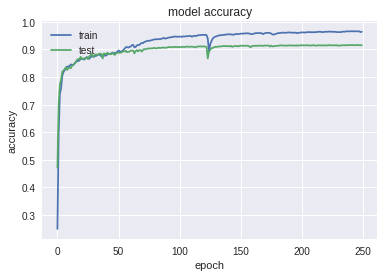

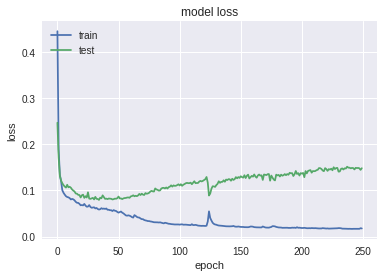

In [28]:
plot_loss(u_net)

In [67]:
!ls

accuracy.png	     dsbowl2018-Unet50-10.csv  test_img.npy   train_mask.npy
datalab		     loss.png		       test_size.npy
datasciencebowl2018  nuclei.model.100.UNET     train_img.npy


In [69]:
import os
from google.colab import files

files.download('accuracy.png')
'''
uploaded = drive.CreateFile({'loss.png': 'loss.png'})
uploaded.SetContentFile('loss.png')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
'''

"\nuploaded = drive.CreateFile({'loss.png': 'loss.png'})\nuploaded.SetContentFile('loss.png')\nuploaded.Upload()\nprint('Uploaded file with ID {}'.format(uploaded.get('id')))\n"

In [27]:
uploaded = drive.CreateFile({'dsbowl2018-Unet150-10': 'dsbowl2018-Unet150-10.csv'})
uploaded.SetContentFile('dsbowl2018-Unet150-10.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1qId9KI_zGqjUnS6fqwXOy_lv6uDrxPbi


In [0]:
import 
from google.colab import files

files.download('nuclei.model.best.UNET')

In [0]:
!kill -9 -1 